In [60]:
from utils.dict_transform import dict2obj

import os 
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np

from helpers.model_adam import Model

from keras.models import Sequential
from keras.layers import (
    Dense, LSTM, LSTMCell, Dropout
)
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.optimizers import adam_v2, sgd_experimental

from sklearn.metrics import (
    mean_absolute_error as mae, 
    mean_squared_error as mse
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from bunch import bunchify

In [2]:
from django.conf import settings

In [33]:
DATASET_DIR = "../datasets/"
MODEL_DIR = "../models/"
FILE_DIR = "./"
SAMPLE = "USD"
INPUTS = [7, 8, 9, 10]

In [4]:
df = pd.read_csv(f"../datasets/{SAMPLE.lower()}-merged.csv", index_col=0, header=0)

# Data Single Fitur Configuration

Pada tahap ini data yang diproses hanya fitur data ***Price*** saja. fitur  ***Open***, ***High***, dan ***Low*** diabaikan.

> **Notes**
>
> perform the process of sharing training and test data, then the data will be normalized in standard form. 

## Data spliting (training & testing)

> **Notes**
> Pembagian data training dan testing menggunakan rasio 80% awal untuk training dan 20% terakhir sebagai testing

In [5]:
# split function
def split(data, n_train=.8, n_test=.2):
    n_data = len(data)
    train_set = data.value.iloc[:round(n_train*n_data)].values
    test_set = data.value.iloc[round(n_train*n_data):].values
    return train_set, test_set

In [6]:
datasets = {}
datasets['train_set'], datasets['test_set'] = split(df)

In [7]:
f"total -> {len(df)} | ", len(datasets['train_set']), len(datasets['test_set'])

('total -> 2557 | ', 2046, 511)

## Scaling data with MinMaxFunction [-1, 1]

\begin{equation}
X\_std = \frac{({X} - {X.min(axis=0)})} {(X.max(axis=0) - X.min(axis=0))}\\
\\
X\_scaled = X\_std * (max - min) + min\\
\end{equation}


In [8]:
# define scaler parameter
scaler = MinMaxScaler(feature_range=(-1, 1))

In [9]:
# data set transformation to metric shape (n_data, 1)
datasets['train_set'] = datasets['train_set'].reshape(
    len(datasets['train_set']), 1
)
datasets['test_set'] = datasets['test_set'].reshape(
    len(datasets['test_set']), 1
)

In [14]:
datasets['train_set_scaled'] = scaler.fit_transform(datasets['train_set'])
datasets['test_set_scaled'] = scaler.fit_transform(datasets['test_set'])

In [ ]:
# convert datatype dict to object

class dict2obj(object):
    def __init__(self, d):
        for a, b in d.items():
            if isinstance(b, (list, tuple)):
                setattr(self, a, [dict2obj(x) if isinstance(x, dict) else x for x in b])
            else:
                setattr(self, a, dict2obj(b) if isinstance(b, dict) else b)

In [25]:
data = dict2obj(datasets)

In [30]:
data.train_set_scaled

array([[-0.56300849],
       [-0.5701522 ],
       [-0.57372405],
       ...,
       [ 0.4523852 ],
       [ 0.47047764],
       [ 0.45869548]])

# Sliding Datasets


In [32]:
def sliding_window(data, window, step_size=1 ):
    X_train = []
    y_train = []
    
    for i in range(window, data.shape[0]):
        X_train.append(data[i-window:i])
        y_train.append(data[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

In [36]:
data.windows = {}

In [37]:
for window in INPUTS:
    data.windows[f'X_train{window}'], data.windows[f'y_train{window}'] = sliding_window(
        data=data.train_set_scaled,
        window=window
    )
    data.windows[f'X_test{window}'], data.windows[f'y_test{window}'] = sliding_window(
        data=data.test_set_scaled,
        window=window
    )

In [44]:
data.windows = dict2obj(data.windows)

In [46]:
data.windows.X_train7.shape

(2039, 7, 1)

# Proposed model design and Experiment design
| No. | Hyperparameters | Accuracy |
| :- | -: | :-: |
| 1* | Unit input/Sliding Window | [7,8,9,10] |
| 2* | Unit Neuron/Block LSTM | [1,2,3,4] |
| 3 | Unit Output/Target | 1 |
| 4 | Epochs | 100 |
| 5 | Hidden Layer (Stacked) | 3 |
| 6* | Optimizer | SGD, Adam |
| 7 | Beta Value | B1 = 0,9 & B2 = 0,99 |
| 8* | Learning Rate | 1; 0,1; 0,01; 0,001 |
| 9 | Batch Size | 32 |
| 10* | Dropout | 0%, 20% |
| 11 | Activate Func | sigmoid & tanh |

# Learning Rate 
- eksperimen dilakukan dengan cara mencari learning rate paling sesuai. pengujian dilakukan dengan nilai 1, 0,1, 0,01 dan 0,001 untuk nilai Learning Rate. Parameter lain akan diatur secara konstan, yaitu sliding window sebesar 1, 2 unit neuron pada hidden layer dan epoch maksimum 1000.


## LR 1

In [117]:
n_data = data.windows.X_train7.shape[0]
X_train = data.windows.X_train7[:round(n_data*.8)]
y_train = data.windows.y_train7[:round(n_data*.8)]
X_validation = data.windows.X_train7[round(n_data*.8):]
y_validation = data.windows.y_train7[round(n_data*.8):]

In [124]:
lr1 = Model()
lr1.set_model(
    name_opt='Adam',
    input_shape=data.windows.X_train7.shape[1],
    neuron_shape=1,
    lr=1
)

NameError: name 'Adam' is not defined

In [125]:
regressor = Sequential()
regressor.add(
    LSTM(units=7, input_shape=(7, 1))
)
regressor.add(Dense(1))

In [126]:
print(regressor.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7)                 252       
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________
None


In [127]:
regressor.compile(
    optimizer=adam_v2.Adam(learning_rate=1, beta_1=.9, beta_2=.999),
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [128]:
regressor.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100, 
    validation_data=(X_validation, y_validation)
)

Epoch 1/100
51/51 [==============================] - 3s 16ms/step - loss: 1.0550 - mean_squared_error: 1.0550 - val_loss: 0.7564 - val_mean_squared_error: 0.7564
Epoch 2/100
51/51 [==============================] - 0s 5ms/step - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.3648 - val_mean_squared_error: 0.3648
Epoch 3/100
51/51 [==============================] - 0s 5ms/step - loss: 0.1101 - mean_squared_error: 0.1101 - val_loss: 0.1572 - val_mean_squared_error: 0.1572
Epoch 4/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0441 - val_mean_squared_error: 0.0441
Epoch 5/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 6/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0764 - val_mean_squared_error: 0.0764
Epoch 7/100
51/51 [==============

In [129]:
regressor.history.model.get_weights()[0].shape

(1, 28)

In [141]:
len(regressor.get_weights())
for weight in regressor.get_weights():
    print(weight.shape)

(1, 28)
(7, 28)
(28,)
(7, 1)
(1,)


In [142]:
regressor.get_config()

{'name': 'sequential_3',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 7, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'lstm_3_input'}},
  {'class_name': 'LSTM',
   'config': {'name': 'lstm_3',
    'trainable': True,
    'batch_input_shape': (None, 7, 1),
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 7,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'a

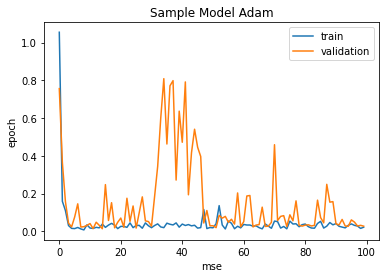

In [135]:
plt.plot(regressor.history.history['mean_squared_error'])
plt.plot(regressor.history.history['val_mean_squared_error'])
plt.title('Sample Model Adam')
plt.xlabel('mse')
plt.ylabel('epoch')
plt.legend(['train', 'validation'])